In [1]:
pip install pandas_datareader

In [2]:
key = '94188f30c93af2e966d88eff1f059121107472ad'

In [3]:
## Data Collection
import pandas_datareader as pdr

In [4]:
df = pdr.get_data_tiingo('AAPL', api_key = key)

C:\Users\yashc\anaconda3\envs\gputest\lib\site-packages\pandas_datareader\tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat(dfs, self._concat_axis)


In [5]:
df.to_csv('AAPL.csv')

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('AAPL.csv')

In [8]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2017-08-16 00:00:00+00:00,160.95,162.51,160.1500,161.94,27321761,38.185926,38.556041,37.996123,38.420806,109287044,0.0,1.0
1,AAPL,2017-08-17 00:00:00+00:00,157.86,160.71,157.8400,160.52,26925694,37.452813,38.128985,37.448068,38.083907,107702776,0.0,1.0
2,AAPL,2017-08-18 00:00:00+00:00,157.50,159.50,156.7200,157.86,27012525,37.367402,37.841908,37.182344,37.452813,108050100,0.0,1.0
3,AAPL,2017-08-21 00:00:00+00:00,157.21,157.89,155.1101,157.50,26145653,37.298598,37.459930,36.800390,37.367402,104582612,0.0,1.0
4,AAPL,2017-08-22 00:00:00+00:00,159.78,160.00,158.0200,158.23,21297812,37.908339,37.960535,37.490773,37.540596,85191248,0.0,1.0


In [9]:
df1 = df.reset_index()['close']

In [10]:
df1

0       160.95
1       157.86
2       157.50
3       157.21
4       159.78
         ...  
1252    164.87
1253    164.92
1254    169.24
1255    168.49
1256    172.10
Name: close, Length: 1257, dtype: float64

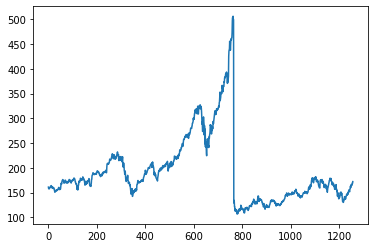

In [11]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [12]:
## LSTM are sensitive to the scale of the data. so we apply MinMax Scaler

In [13]:
import numpy  as np

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [15]:
df1

array([[0.13552912],
       [0.12778961],
       [0.12688791],
       ...,
       [0.15629305],
       [0.15441453],
       [0.16345648]])

In [16]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [17]:
training_size,test_size

(817, 440)

In [18]:
#Converting into dependent and independent feature based on timestamp
#Data                                  testData
#120,130,125,140,134,150                    160,190,154,160,170

#timesteps=3
# X_train    X_test                       Y_train
#f1  f2  f3  o/p                           f1  f2  f3  o/p(Y_test)
#120 130 125 140                          160 190 154  160
#130 125 140 134                          190 154 160  170

In [19]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [20]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [21]:
print(X_train.shape), print(Y_train.shape)

(716, 100)
(716,)


(None, None)

In [22]:
print(X_test.shape), print(Y_test.shape)

(339, 100)
(339,)


(None, None)

In [23]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [24]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [25]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 68s 1s/step - loss: 0.0429 - val_loss: 0.0029
Epoch 2/100
12/12 [==============================] - 5s 408ms/step - loss: 0.0141 - val_loss: 0.0025
Epoch 3/100
12/12 [==============================] - 4s 303ms/step - loss: 0.0104 - val_loss: 3.3243e-04
Epoch 4/100
12/12 [==============================] - 4s 343ms/step - loss: 0.0091 - val_loss: 3.6478e-04
Epoch 5/100
12/12 [==============================] - 5s 445ms/step - loss: 0.0098 - val_loss: 0.0018
Epoch 6/100
12/12 [==============================] - 4s 355ms/step - loss: 0.0083 - val_loss: 5.8772e-04
Epoch 7/100
12/12 [==============================] - 6s 504ms/step - loss: 0.0066 - val_loss: 4.6649e-04
Epoch 8/100
12/12 [==============================] - 4s 361ms/step - loss: 0.0078 - val_loss: 9.2371e-04
Epoch 9/100
12/12 [==============================] - 5s 374ms/step - loss: 0.0069 - val_loss: 3.3809e-04
Epoch 10/100
12/12 [==============================] - 4s 323ms/step -

In [31]:
 import tensorflow as tf

In [32]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 2s 192ms/step


In [33]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [35]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_train,train_predict))

233.7822521123181

In [37]:
### Test Data RMSE
math.sqrt(mean_squared_error(Y_test,test_predict))

159.30544491149345

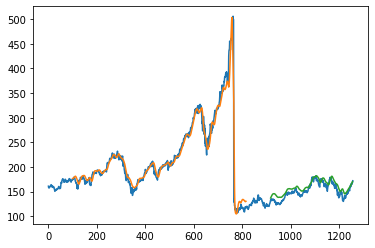

In [38]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [43]:
## Predicting the output of next 30 days

In [39]:
len(test_data)

440

In [48]:
x_input=test_data[340:].reshape(1,-1)
x_input.shape

(1, 100)

In [49]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [50]:
temp_input

[0.1552410770194113,
 0.1587226048841578,
 0.16839073262366933,
 0.17001878522229175,
 0.17222291797119593,
 0.18063869755792106,
 0.1776581089542893,
 0.16974326862867878,
 0.16899185973700687,
 0.1793362554790231,
 0.17087038196618654,
 0.16278021289918598,
 0.1635566687539135,
 0.158422041327489,
 0.14755165936130238,
 0.1523356293049467,
 0.15919849718221663,
 0.14639949906073885,
 0.1458484658735128,
 0.15168440826549778,
 0.15125860989355033,
 0.14922980588603624,
 0.13763306199123349,
 0.140363180964308,
 0.1251346274264245,
 0.12455854727614268,
 0.14226675015654344,
 0.12726361928616153,
 0.12804007514088916,
 0.13184721352536,
 0.14822792736380713,
 0.12505948653725735,
 0.12633688165309953,
 0.11326236693800873,
 0.11939887288666245,
 0.09933625547902314,
 0.08946775203506574,
 0.10086412022542268,
 0.09693174702567309,
 0.10619912335629306,
 0.08510958046336875,
 0.0764182842830306,
 0.07701941139636814,
 0.09084533500313086,
 0.08395742016280527,
 0.0843581715716969,
 0.09

In [51]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.16319653]
101
1 day input [0.1587226  0.16839073 0.17001879 0.17222292 0.1806387  0.17765811
 0.16974327 0.16899186 0.17933626 0.17087038 0.16278021 0.16355667
 0.15842204 0.14755166 0.15233563 0.1591985  0.1463995  0.14584847
 0.15168441 0.15125861 0.14922981 0.13763306 0.14036318 0.12513463
 0.12455855 0.14226675 0.12726362 0.12804008 0.13184721 0.14822793
 0.12505949 0.12633688 0.11326237 0.11939887 0.09933626 0.08946775
 0.10086412 0.09693175 0.10619912 0.08510958 0.07641828 0.07701941
 0.09084534 0.08395742 0.08435817 0.09252348 0.107201   0.10519724
 0.10487163 0.11113338 0.096531   0.09843456 0.10487163 0.10299311
 0.08966813 0.07586725 0.0627176  0.06492173 0.07160927 0.05815905
 0.06191609 0.07271133 0.07140889 0.0787226  0.08721353 0.08721353
 0.07664371 0.08112711 0.07484033 0.0803757  0.08696306 0.09036944
 0.09896055 0.10068879 0.0952536  0.09773325 0.09680651 0.10427051
 0.10852849 0.10076393 0.11060739 0.11571697 0.12150282 0.1183469
 0.11549155 0.11211021 0.12510958 

In [52]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [53]:
import matplotlib.pyplot as plt

In [54]:
len(df1)

1257

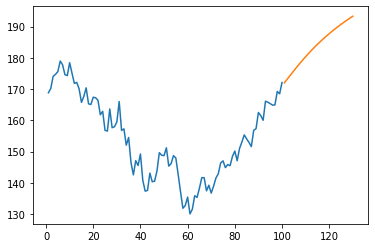

In [56]:
plt.plot(day_new,scaler.inverse_transform(df1[1157:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

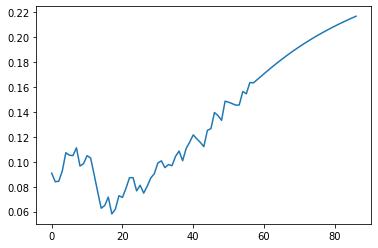

In [57]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [58]:
df3=scaler.inverse_transform(df3).tolist()

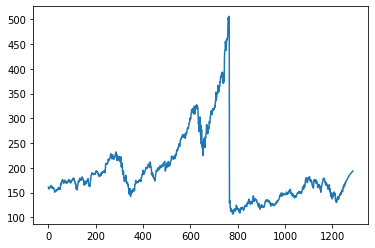

In [59]:
plt.plot(df3)